# Case Study Analysis Notebook: Flagstaff

The purpose of this code is to understand why the Flagstaff Depth to Water graphs indicate massive declines but not the individual wells.  It clips wells from a shapefile and creates a timeseries of wells by drilling depth.  It is a combination of many of the other notebooks consolidated into this one.

The conclusion was that wells drilled deeper in more recent years are skewing our spatial averages of depth to water.

To run this code, you need the following files in the appropriate folders:
 - Data/Input
   - Yearly_DroughtIndices_updated[your date].csv
 - Data/Output/Local
   - Master_ADWR_database_noduplicates.shp
   - Master_ADWR_database_water.shp
   - Wells55_GWSI_WLTS_DB_annual_updated_thresh15outliersdeleted.csv
 - Data/Input/Shapefiles
   - Flagstaff city limits shapefile buffered by 500 meters

In [1]:
# Packages and paths
# %%
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gp
import scipy.stats as sp
import sys

# Add the path to the Utils folder
utils_path = os.path.abspath(os.path.join('..', 'Utils'))
if utils_path not in sys.path:
    sys.path.append(utils_path)

# Now you can import the functions from CustomFunctions.py

# Local paths
datapath = '../../Data'
inputpath = '../../Data/Input'
outputpath = '../../Data/Output/Local'
shapepath = inputpath+'/Shapefiles'
figurepath = '../../Figures/Local'

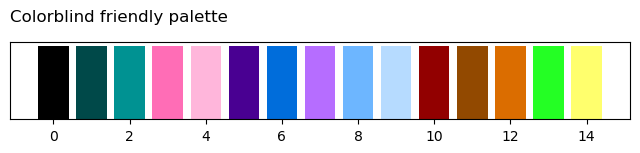

In [11]:
drought_color = '#ffa6b8'

# Color blind palette
# https://jacksonlab.agronomy.wisc.edu/2016/05/23/15-level-colorblind-friendly-palette/
cblind =["#000000","#004949","#009292","#ff6db6","#ffb6db",
 "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
 "#920000","#924900","#db6d00","#24ff24","#ffff6d"]

palette = cblind
fig, ax = plt.subplots(figsize=(8, 1))
ax.bar(range(len(palette)), height=1, color=palette)
ax.set_title('Colorblind friendly palette',loc='left',pad=15)
# Remove y-axis
ax.set_yticks([])
plt.show()


In [3]:
# %% Drought dictionary
DROUGHT_YEARS = {
        # 1:[1989,1990]
        # ,2:[1996]
        3:[2002,2003]
        ,4:[2006,2007]
        ,5:[2012,2013,2014]
        ,6:[2018]
        ,7:[2021]}

print(DROUGHT_YEARS)

{3: [2002, 2003], 4: [2006, 2007], 5: [2012, 2013, 2014], 6: [2018], 7: [2021]}


In [4]:
#%% Pre-drought
# PREDROUGHT_YEARS = {1:[1988]
#         ,2:[1995]
#         ,3:[2001]
#         ,4:[2005]
#         ,5:[2011]
#         ,6:[2017]}

PREDROUGHT_YEARS = {1:[*range(1975,1988,1)]
        ,2:[*range(1991,1995,1)]
        ,3:[*range(1997,2001,1)]
        ,4:[*range(2004,2005,1)]
        ,5:[*range(2006,2011,1)]
        ,6:[*range(2015,2017,1)]}

print(PREDROUGHT_YEARS)

{1: [1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987], 2: [1991, 1992, 1993, 1994], 3: [1997, 1998, 1999, 2000], 4: [2004], 5: [2006, 2007, 2008, 2009, 2010], 6: [2015, 2016]}


Read in the main databases.  You only have to do this once.

Master Database might take a while (~5-7 minutes).

In [5]:
# Read in the main Static Database

filename_mdb_nd = 'Master_ADWR_database_noduplicates.shp'
filepath = os.path.join(outputpath, filename_mdb_nd)
print(filepath)

masterdb = gp.read_file(filepath)
pd.options.display.float_format = '{:.2f}'.format
print(masterdb.info())

../../Data/Output/Local\Master_ADWR_database_noduplicates.shp
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 254720 entries, 0 to 254719
Data columns (total 80 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   Combo_ID    254720 non-null  object  
 1   OBJECTID_g  45631 non-null   float64 
 2   SITE_ID     45631 non-null   object  
 3   LOCAL_ID    45631 non-null   object  
 4   REGISTRY_I  233584 non-null  object  
 5   WELL_TYPE   45631 non-null   object  
 6   DD_LAT      45631 non-null   float64 
 7   DD_LONG     45631 non-null   float64 
 8   LAT_NAD27   45631 non-null   object  
 9   LONG_NAD27  45631 non-null   object  
 10  WELL_ALT    45631 non-null   float64 
 11  WATER_USE_  45573 non-null   object  
 12  WELL_DEPTH  214498 non-null  float64 
 13  CASE_DIAM   33772 non-null   float64 
 14  WL_COUNT    45631 non-null   float64 
 15  WL_DTW      34716 non-null   float64 
 16  WL_ELEV     34716 non-null   float64 
 1

This one takes about 3-4 minutes to run

In [6]:
# Read in the database of number water wells
filename_mdb_w = 'Master_ADWR_database_water.shp'
filepath = os.path.join(outputpath, filename_mdb_w)
print(filepath)

masterdb_water = gp.read_file(filepath)
pd.options.display.float_format = '{:.2f}'.format
print(masterdb_water.info())

../../Data/Output/Local\Master_ADWR_database_water.shp
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 142717 entries, 0 to 142716
Data columns (total 80 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   Combo_ID    142717 non-null  object  
 1   OBJECTID_g  45631 non-null   float64 
 2   SITE_ID     45631 non-null   object  
 3   LOCAL_ID    45631 non-null   object  
 4   REGISTRY_I  121581 non-null  object  
 5   WELL_TYPE   45631 non-null   object  
 6   DD_LAT      45631 non-null   float64 
 7   DD_LONG     45631 non-null   float64 
 8   LAT_NAD27   45631 non-null   object  
 9   LONG_NAD27  45631 non-null   object  
 10  WELL_ALT    45631 non-null   float64 
 11  WATER_USE_  45573 non-null   object  
 12  WELL_DEPTH  130667 non-null  float64 
 13  CASE_DIAM   33772 non-null   float64 
 14  WL_COUNT    45631 non-null   float64 
 15  WL_DTW      34716 non-null   float64 
 16  WL_ELEV     34716 non-null   float64 
 17  SOUR

In [7]:
# Read in the annual time series database
# This file was created in Well_Timeseries_merge.py

filename_ts = 'Wells55_GWSI_WLTS_DB_annual_updated_thresh15outliersdeleted.csv'
filepath = os.path.join(outputpath, filename_ts)
print(filepath)
annual_db = pd.read_csv(filepath, header=1, index_col=0)

#Block to do some formatting
annual_db = annual_db[1:168102]
annual_db.index = annual_db.index.astype('int64')
annual_db2 = annual_db.reset_index(inplace=True)
annual_db2 = annual_db.rename(columns = {'year':'Combo_ID'})
annual_db2.head()

../../Data/Output/Local\Wells55_GWSI_WLTS_DB_annual_updated_thresh15outliersdeleted.csv


,Combo_ID,1853.0,1856.0,1857.0,1860.0,1864.0,1868.0,1870.0,1871.0,1872.0,...,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0,2024.0
0,60001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,497.70,495.30,NaN,489.85,NaN,487.85,485.10,483.50,483.90,NaN
1,85358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,262.43,254.88,251.65,251.53,NaN,NaN,NaN,NaN,NaN
2,85761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,44.70,45.50,45.30,46.30,45.00,46.20,43.50,41.40,45.80,NaN
3,85799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,59.30,59.80,57.80,59.50,60.10,59.40,60.80,62.10,62.10,NaN
4,85863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,114.74,115.50,116.26,117.10,119.34,118.49,119.77,120.65,119.83,120.71


### From here down is where you can rerun the code to generate graphs

<Axes: >

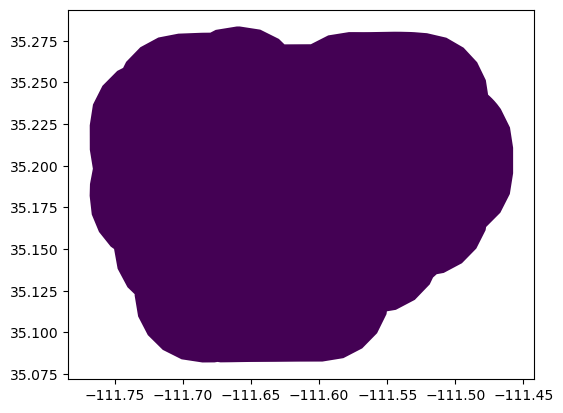

In [8]:
# Read in the shapefile

# filename_shapeile = 'georeg_reproject_fixed.shp'
filename_shapeile = 'Flagstaff_buffered.shp'
filepath = os.path.join(shapepath, filename_shapeile)
shapefile = gp.read_file(filepath)
shapefile.plot(cmap='viridis')


In [9]:
shapefile

,Name,FID,AMA_CODE,SUBBASIN_N,NAME_ABBR,SUBBASIN_1,SHAPEAREA,layer,path,geometry
0,Flagstaff,14,NaN,NaN,NaN,NaN,NaN,Flagstaff_Buffered,/Users/danielletadych/Documents/PhD_Materials/...,"POLYGON Z ((-111.76613 35.19826 0.00000, -111...."


In [12]:
# Define some things about your file

StudyArea = "Flagstaff_0352024"
Naming_col = "Name"

Merging the databases takes a little time - Approximately 3 minutes

In [ ]:
# Merge the shapefile with the master database

shapefile = shapefile.to_crs(epsg=26912)
masterdb2 = masterdb.set_crs(epsg=26912)
masterdb_water = masterdb_water.set_crs(epsg=26912)
# For main static database
static_geo = gp.sjoin(masterdb2, shapefile, how="inner", op='intersects')

print(str(filename_mdb_nd) + " and " + str(filename_shapeile) + " join complete.")

# %% For the water wells water wells
static_geo2 = gp.sjoin(masterdb_water, shapefile, how="inner", op='intersects')
static_geo2.head()
print(str(filename_mdb_nd) + " and " + str(filename_shapeile) + " join complete.")


c:\Users\det19\.conda\envs\azgwspatialanalysis\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Master_ADWR_database_noduplicates.shp and Flagstaff_buffered.shp join complete.


c:\Users\det19\.conda\envs\azgwspatialanalysis\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Master_ADWR_database_noduplicates.shp and Flagstaff_buffered.shp join complete.


In [ ]:
static_geo

,Combo_ID,OBJECTID_g,SITE_ID,LOCAL_ID,REGISTRY_I,WELL_TYPE,DD_LAT,DD_LONG,LAT_NAD27,LONG_NAD27,...,index_right,Name,FID,AMA_CODE,SUBBASIN_N_right,NAME_ABBR,SUBBASIN_1,SHAPEAREA,layer,path
666,085704,NaN,NaN,NaN,085704,NaN,NaN,NaN,NaN,NaN,...,0,Flagstaff,14,NaN,NaN,NaN,NaN,NaN,Flagstaff_Buffered,/Users/danielletadych/Documents/PhD_Materials/...
2516,087825,NaN,NaN,NaN,087825,NaN,NaN,NaN,NaN,NaN,...,0,Flagstaff,14,NaN,NaN,NaN,NaN,NaN,Flagstaff_Buffered,/Users/danielletadych/Documents/PhD_Materials/...
2721,200199,NaN,NaN,NaN,200199,NaN,NaN,NaN,NaN,NaN,...,0,Flagstaff,14,NaN,NaN,NaN,NaN,NaN,Flagstaff_Buffered,/Users/danielletadych/Documents/PhD_Materials/...
2838,200318,NaN,NaN,NaN,200318,NaN,NaN,NaN,NaN,NaN,...,0,Flagstaff,14,NaN,NaN,NaN,NaN,NaN,Flagstaff_Buffered,/Users/danielletadych/Documents/PhD_Materials/...
3122,200610,NaN,NaN,NaN,200610,NaN,NaN,NaN,NaN,NaN,...,0,Flagstaff,14,NaN,NaN,NaN,NaN,NaN,Flagstaff_Buffered,/Users/danielletadych/Documents/PhD_Materials/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254114,930565,NaN,NaN,NaN,930565,NaN,NaN,NaN,NaN,NaN,...,0,Flagstaff,14,NaN,NaN,NaN,NaN,NaN,Flagstaff_Buffered,/Users/danielletadych/Documents/PhD_Materials/...
254244,930700,NaN,NaN,NaN,930700,NaN,NaN,NaN,NaN,NaN,...,0,Flagstaff,14,NaN,NaN,NaN,NaN,NaN,Flagstaff_Buffered,/Users/danielletadych/Documents/PhD_Materials/...
254245,930701,NaN,NaN,NaN,930701,NaN,NaN,NaN,NaN,NaN,...,0,Flagstaff,14,NaN,NaN,NaN,NaN,NaN,Flagstaff_Buffered,/Users/danielletadych/Documents/PhD_Materials/...
254246,930702,NaN,NaN,NaN,930702,NaN,NaN,NaN,NaN,NaN,...,0,Flagstaff,14,NaN,NaN,NaN,NaN,NaN,Flagstaff_Buffered,/Users/danielletadych/Documents/PhD_Materials/...


In [ ]:
# Pull out the columns you need
# Use this or subbasins:
# reg_list = static_geo[['Combo_ID', Naming_col+'_right','WELL_DEPTH','WELL_TYPE_']]
# Use this or cities:
reg_list = static_geo[['Combo_ID', Naming_col,'WELL_DEPTH','WELL_TYPE_']]
# reg_list

# %% Converting Combo_ID to int
reg_list['Combo_ID'] = reg_list['Combo_ID'].astype(np.int64, errors = 'raise')

C:\Users\det19\AppData\Local\Temp\ipykernel_23844\1936538389.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_list['Combo_ID'] = reg_list['Combo_ID'].astype(np.int64, errors = 'raise')


In [ ]:
# Merging the Timeseries and the shapefile static database
combo = annual_db2.merge(reg_list, how="inner")
combo.info()

# %% set index to Combo_ID
combo.set_index('Combo_ID', inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Columns: 164 entries, Combo_ID to WELL_TYPE_
dtypes: float64(161), int64(1), object(2)
memory usage: 11.7+ KB


Doing some Q/A to figure out what's going on with these wells and why the slopes are different than the spatial average

In [ ]:
test = combo.copy()
test = test.drop(['WELL_DEPTH','WELL_TYPE_','Name'],axis=1)
test

,1853.0,1856.0,1857.0,1860.0,1864.0,1868.0,1870.0,1871.0,1872.0,1873.0,...,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0,2024.0
Combo_ID,,,,,,,,,,,,,,,,,,,,,
509491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,123.40,123.67,123.85,124.55,NaN,NaN,NaN,NaN,NaN,NaN
559571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,926.66,926.66,926.68,927.15,927.23,927.47,927.48,927.46,927.90,927.49
600511,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,171.80,188.20,164.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,74.07,78.87,67.20,73.20,68.70,73.03,76.17,77.65,67.20,NaN
637392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1310.40,1311.57,1311.13,1309.92,1310.10,1309.80,1310.03,1309.65,1311.33,NaN
647022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,50.73,52.37,51.08,56.58,48.27,53.90,53.08,46.93,46.40,NaN
808126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,104.50,120.80,79.90,135.00,80.10,80.80,79.80,81.50,81.20,NaN
351556111430401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,185.67,185.60,185.15,183.62,185.07,184.53,185.38,184.82,182.50,NaN
351620111433201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,125.13,124.77,119.35,120.42,121.67,120.88,127.17,125.05,118.30,NaN


In [ ]:
# Clean up the dataframe for graphing
test = test.copy()
i = test
# del i['WELL_DEPTH']
f = i.transpose()
f.reset_index(inplace=True)
f['index'] = pd.to_numeric(f['index'])
f['index'] = f['index'].astype(int)
f.set_index('index', inplace=True)
f.info()
test = f
test

<class 'pandas.core.frame.DataFrame'>
Index: 160 entries, 1853 to 2024
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   509491           31 non-null     float64
 1   559571           29 non-null     float64
 2   600511           30 non-null     float64
 3   608396           34 non-null     float64
 4   637392           19 non-null     float64
 5   647022           36 non-null     float64
 6   808126           51 non-null     float64
 7   351556111430401  35 non-null     float64
 8   351620111433201  36 non-null     float64
dtypes: float64(9)
memory usage: 11.9 KB


Combo_ID,509491,559571,600511,608396,637392,647022,808126,351556111430401,351620111433201
index,,,,,,,,,
1853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1864,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2020,NaN,927.47,NaN,73.03,1309.80,53.90,80.80,184.53,120.88
2021,NaN,927.48,NaN,76.17,1310.03,53.08,79.80,185.38,127.17
2022,NaN,927.46,NaN,77.65,1309.65,46.93,81.50,184.82,125.05


<Axes: xlabel='index'>

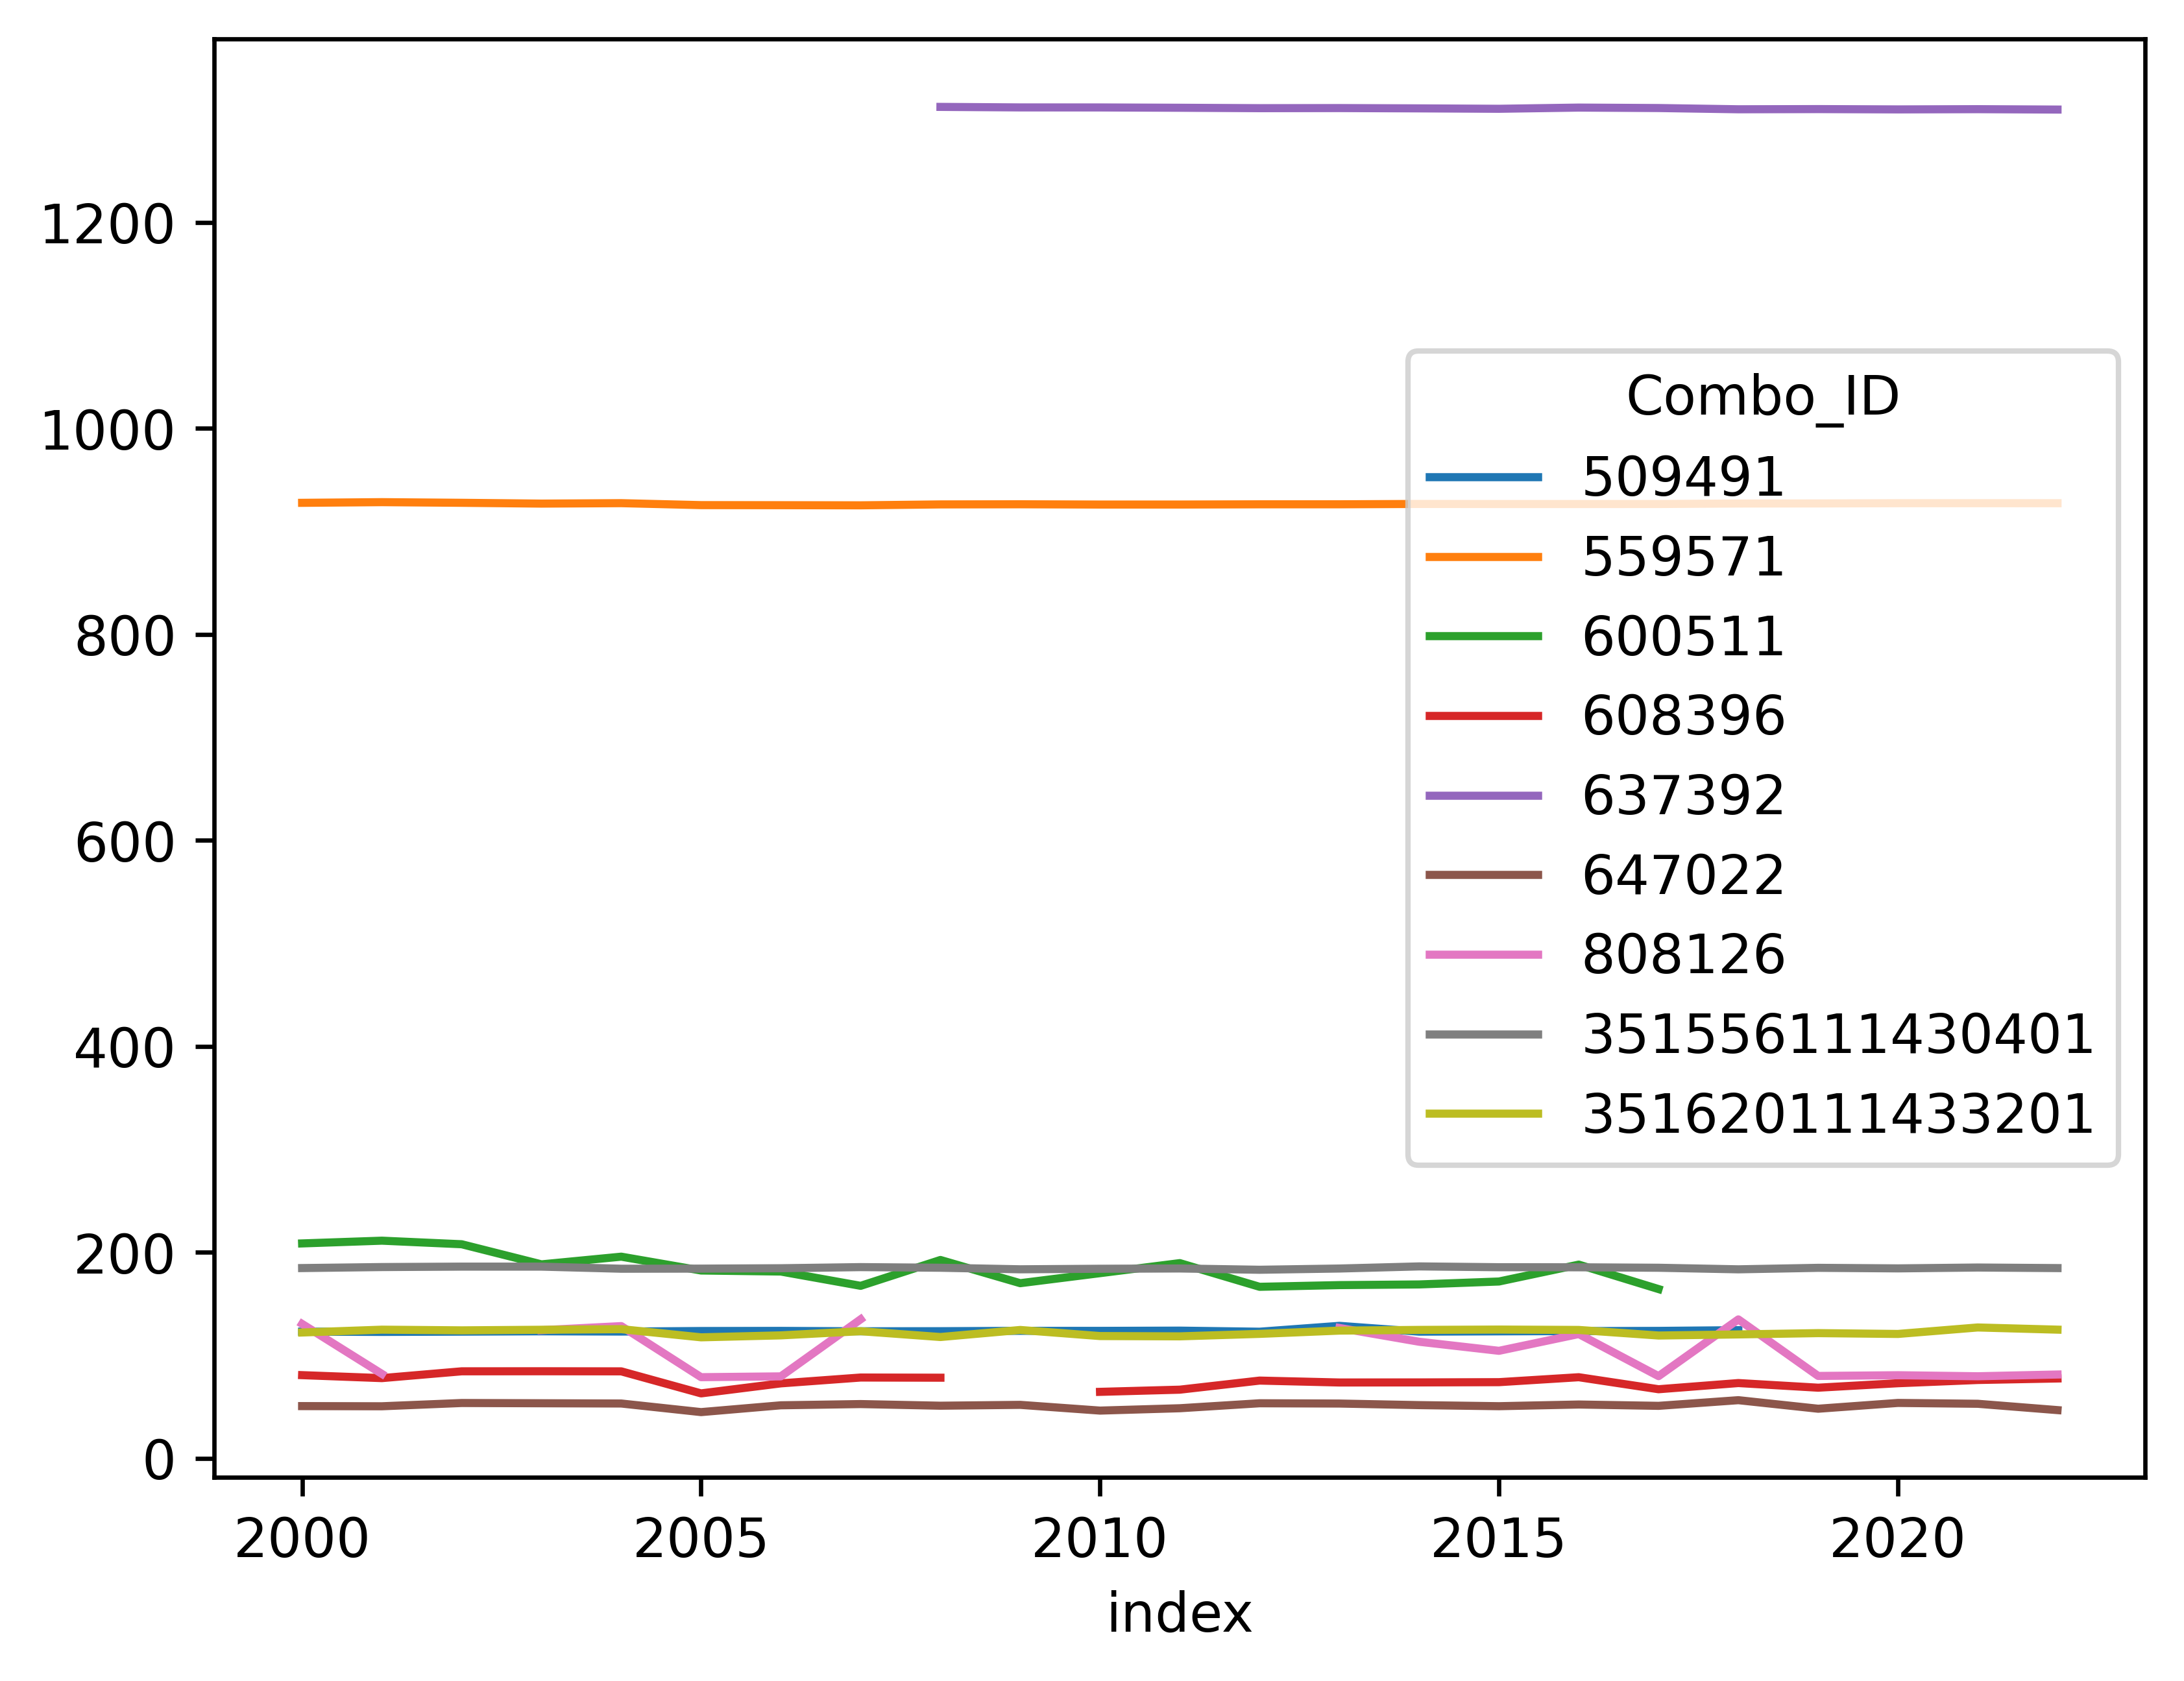

In [ ]:
Min_year_of_Study = 2000
test_plotting = test[(test.index>=Min_year_of_Study)&(test.index<=2022)]
test_plotting.plot()

Checked the Combo_ID's of 559671 and 637392 and found out
1) they are both drilled into a deeper aquifer (1800 feet depth!)
2) they are both transducer wells
3) all other wells are shallow

I think the best thing then would be to group by Shallow and Deep

In [ ]:
# Create a function to apply the criteria
def categorize_depth(depth):
    if depth < 200:
        return "Shallow"
    elif 200 <= depth <= 500:
        return "Midrange"
    else:
        return "Deep"

# Apply the function to create a new column
combo['Depth_Category'] = combo['WELL_DEPTH'].apply(categorize_depth)
combo

,1853.0,1856.0,1857.0,1860.0,1864.0,1868.0,1870.0,1871.0,1872.0,1873.0,...,2019.0,2020.0,2021.0,2022.0,2023.0,2024.0,Name,WELL_DEPTH,WELL_TYPE_,Depth_Category
Combo_ID,,,,,,,,,,,,,,,,,,,,,
509491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Flagstaff,155.00,EXEMPT,Shallow
559571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,927.23,927.47,927.48,927.46,927.90,927.49,Flagstaff,1800.00,NON-EXEMPT,Deep
600511,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Flagstaff,320.00,EXEMPT,Midrange
608396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,68.70,73.03,76.17,77.65,67.20,NaN,Flagstaff,135.00,NON-EXEMPT,Shallow
637392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1310.10,1309.80,1310.03,1309.65,1311.33,NaN,Flagstaff,1800.00,EXEMPT,Deep
647022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.27,53.90,53.08,46.93,46.40,NaN,Flagstaff,60.00,EXEMPT,Shallow
808126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,80.10,80.80,79.80,81.50,81.20,NaN,Flagstaff,140.00,EXEMPT,Shallow
351556111430401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,185.07,184.53,185.38,184.82,182.50,NaN,Flagstaff,268.00,NaN,Midrange
351620111433201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,121.67,120.88,127.17,125.05,118.30,NaN,Flagstaff,150.00,NaN,Shallow


In [ ]:
# Grouping the appropriate column
combo_copy = combo.copy()
combo_copy = combo_copy.drop(['WELL_DEPTH','WELL_TYPE_','Name'],axis=1)
# cat_wl = combo_copy.groupby([Naming_col+"_right"]).mean()
cat_wl = combo_copy.groupby(['Depth_Category']).mean()

In [ ]:
# Clean up the dataframe for graphing
cat_wl2 = cat_wl.copy()
i = cat_wl2
# del i['WELL_DEPTH']
f = i.transpose()
f.reset_index(inplace=True)
f['index'] = pd.to_numeric(f['index'])
f['index'] = f['index'].astype(int)
f.set_index('index', inplace=True)
f.info()
cat_wl2 = f
cat_wl2

<class 'pandas.core.frame.DataFrame'>
Index: 160 entries, 1853 to 2024
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Deep      31 non-null     float64
 1   Midrange  36 non-null     float64
 2   Shallow   56 non-null     float64
dtypes: float64(3)
memory usage: 4.4 KB


Depth_Category,Deep,Midrange,Shallow
index,,,
1853,NaN,NaN,NaN
1856,NaN,NaN,NaN
1857,NaN,NaN,NaN
1860,NaN,NaN,NaN
1864,NaN,NaN,NaN
...,...,...,...
2020,1118.63,184.53,82.15
2021,1118.75,185.38,84.06
2022,1118.55,184.82,82.78


In [ ]:
cat_wl2.head(-1)

Depth_Category,Deep,Midrange,Shallow
index,,,
1853,NaN,NaN,NaN
1856,NaN,NaN,NaN
1857,NaN,NaN,NaN
1860,NaN,NaN,NaN
1864,NaN,NaN,NaN
...,...,...,...
2019,1118.66,185.07,79.69
2020,1118.63,184.53,82.15
2021,1118.75,185.38,84.06


In [ ]:
# Export the dataframe
# cat_wl2_reg.to_csv(outputpath_local+'Waterlevels_Regulation_updated_thresh15outliersdeleted.csv')

### Analysis and Graphing

In [ ]:
# Read in the drought indices

#  Input the date you downloaded the drought files
date_downloaded = "06102024"

drought_indices = pd.read_csv(f'{inputpath}/Yearly_DroughtIndices_updated{date_downloaded}.csv')
drought_indices = drought_indices.set_index('In_year')

In [ ]:
Min_year_of_Study = 2000

# Water Analysis period
wlanalysis_period = cat_wl2[(cat_wl2.index>=Min_year_of_Study)&(cat_wl2.index<=2022)]
drought_indices = drought_indices[(drought_indices.index>=Min_year_of_Study)&(drought_indices.index<=2022)]
# del wlanalysis_period['Res'] # Only run this if doing regulation shapefile
wlanalysis_period.head()

Depth_Category,Deep,Midrange,Shallow
index,,,
2000,927.83,196.81,101.54
2001,1121.69,198.63,91.73
2002,927.85,197.11,96.48
2003,927.07,187.34,102.23
2004,927.50,190.06,103.03


This is helpful if you're missing values and it won't calculate statistics

In [ ]:
df_interpolated = wlanalysis_period.interpolate(method='linear', axis=0)
df_interpolated

Depth_Category,Deep,Midrange,Shallow
index,,,
2000,927.83,196.81,101.54
2001,1121.69,198.63,91.73
2002,927.85,197.11,96.48
2003,927.07,187.34,102.23
2004,927.50,190.06,103.03
2005,925.60,183.39,85.68
2006,925.52,183.07,89.51
2007,925.40,176.68,102.69
2008,1119.26,188.93,92.76


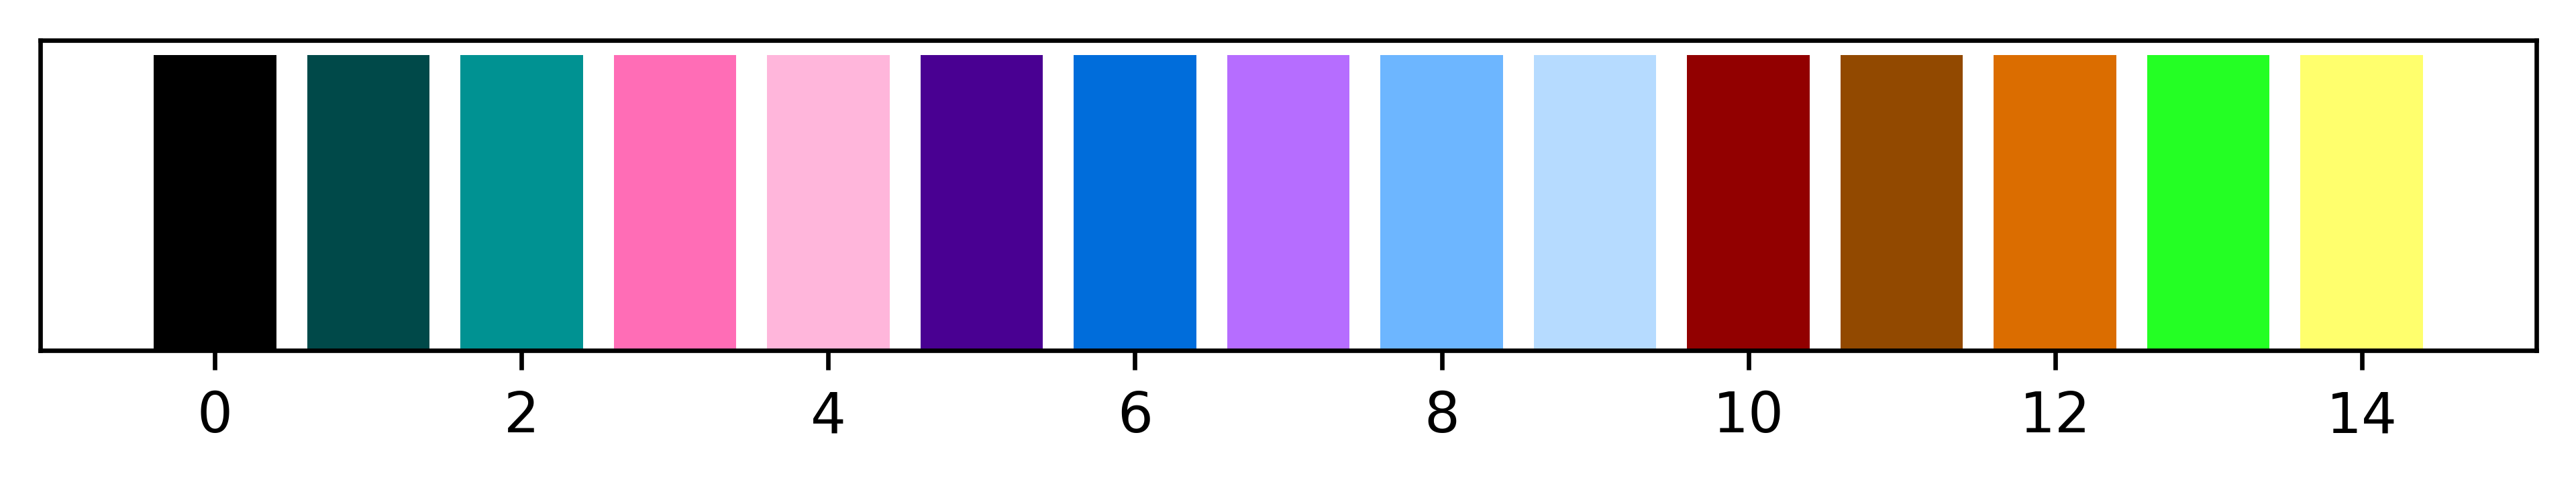

In [ ]:
# Create a bar plot to visualize colors
fig, ax = plt.subplots(figsize=(8, 1))
ax.bar(range(len(cblind)), height=1, color=cblind)

# Remove y-axis
ax.set_yticks([])

# Show the plot
plt.show()

In [ ]:
color_list = [cblind[0],cblind[1],cblind[2]]

             Deep  Midrange  Shallow
slope        9.44     -0.50    -0.54
int     -17924.18   1191.71  1179.84
rsq          0.50      0.24     0.23
p_val        0.00      0.02     0.02
std_err      2.06      0.19     0.22
mean      1060.45    184.39    93.66
var       7829.58     45.33    56.62
sum      24390.39   4240.87  2154.17


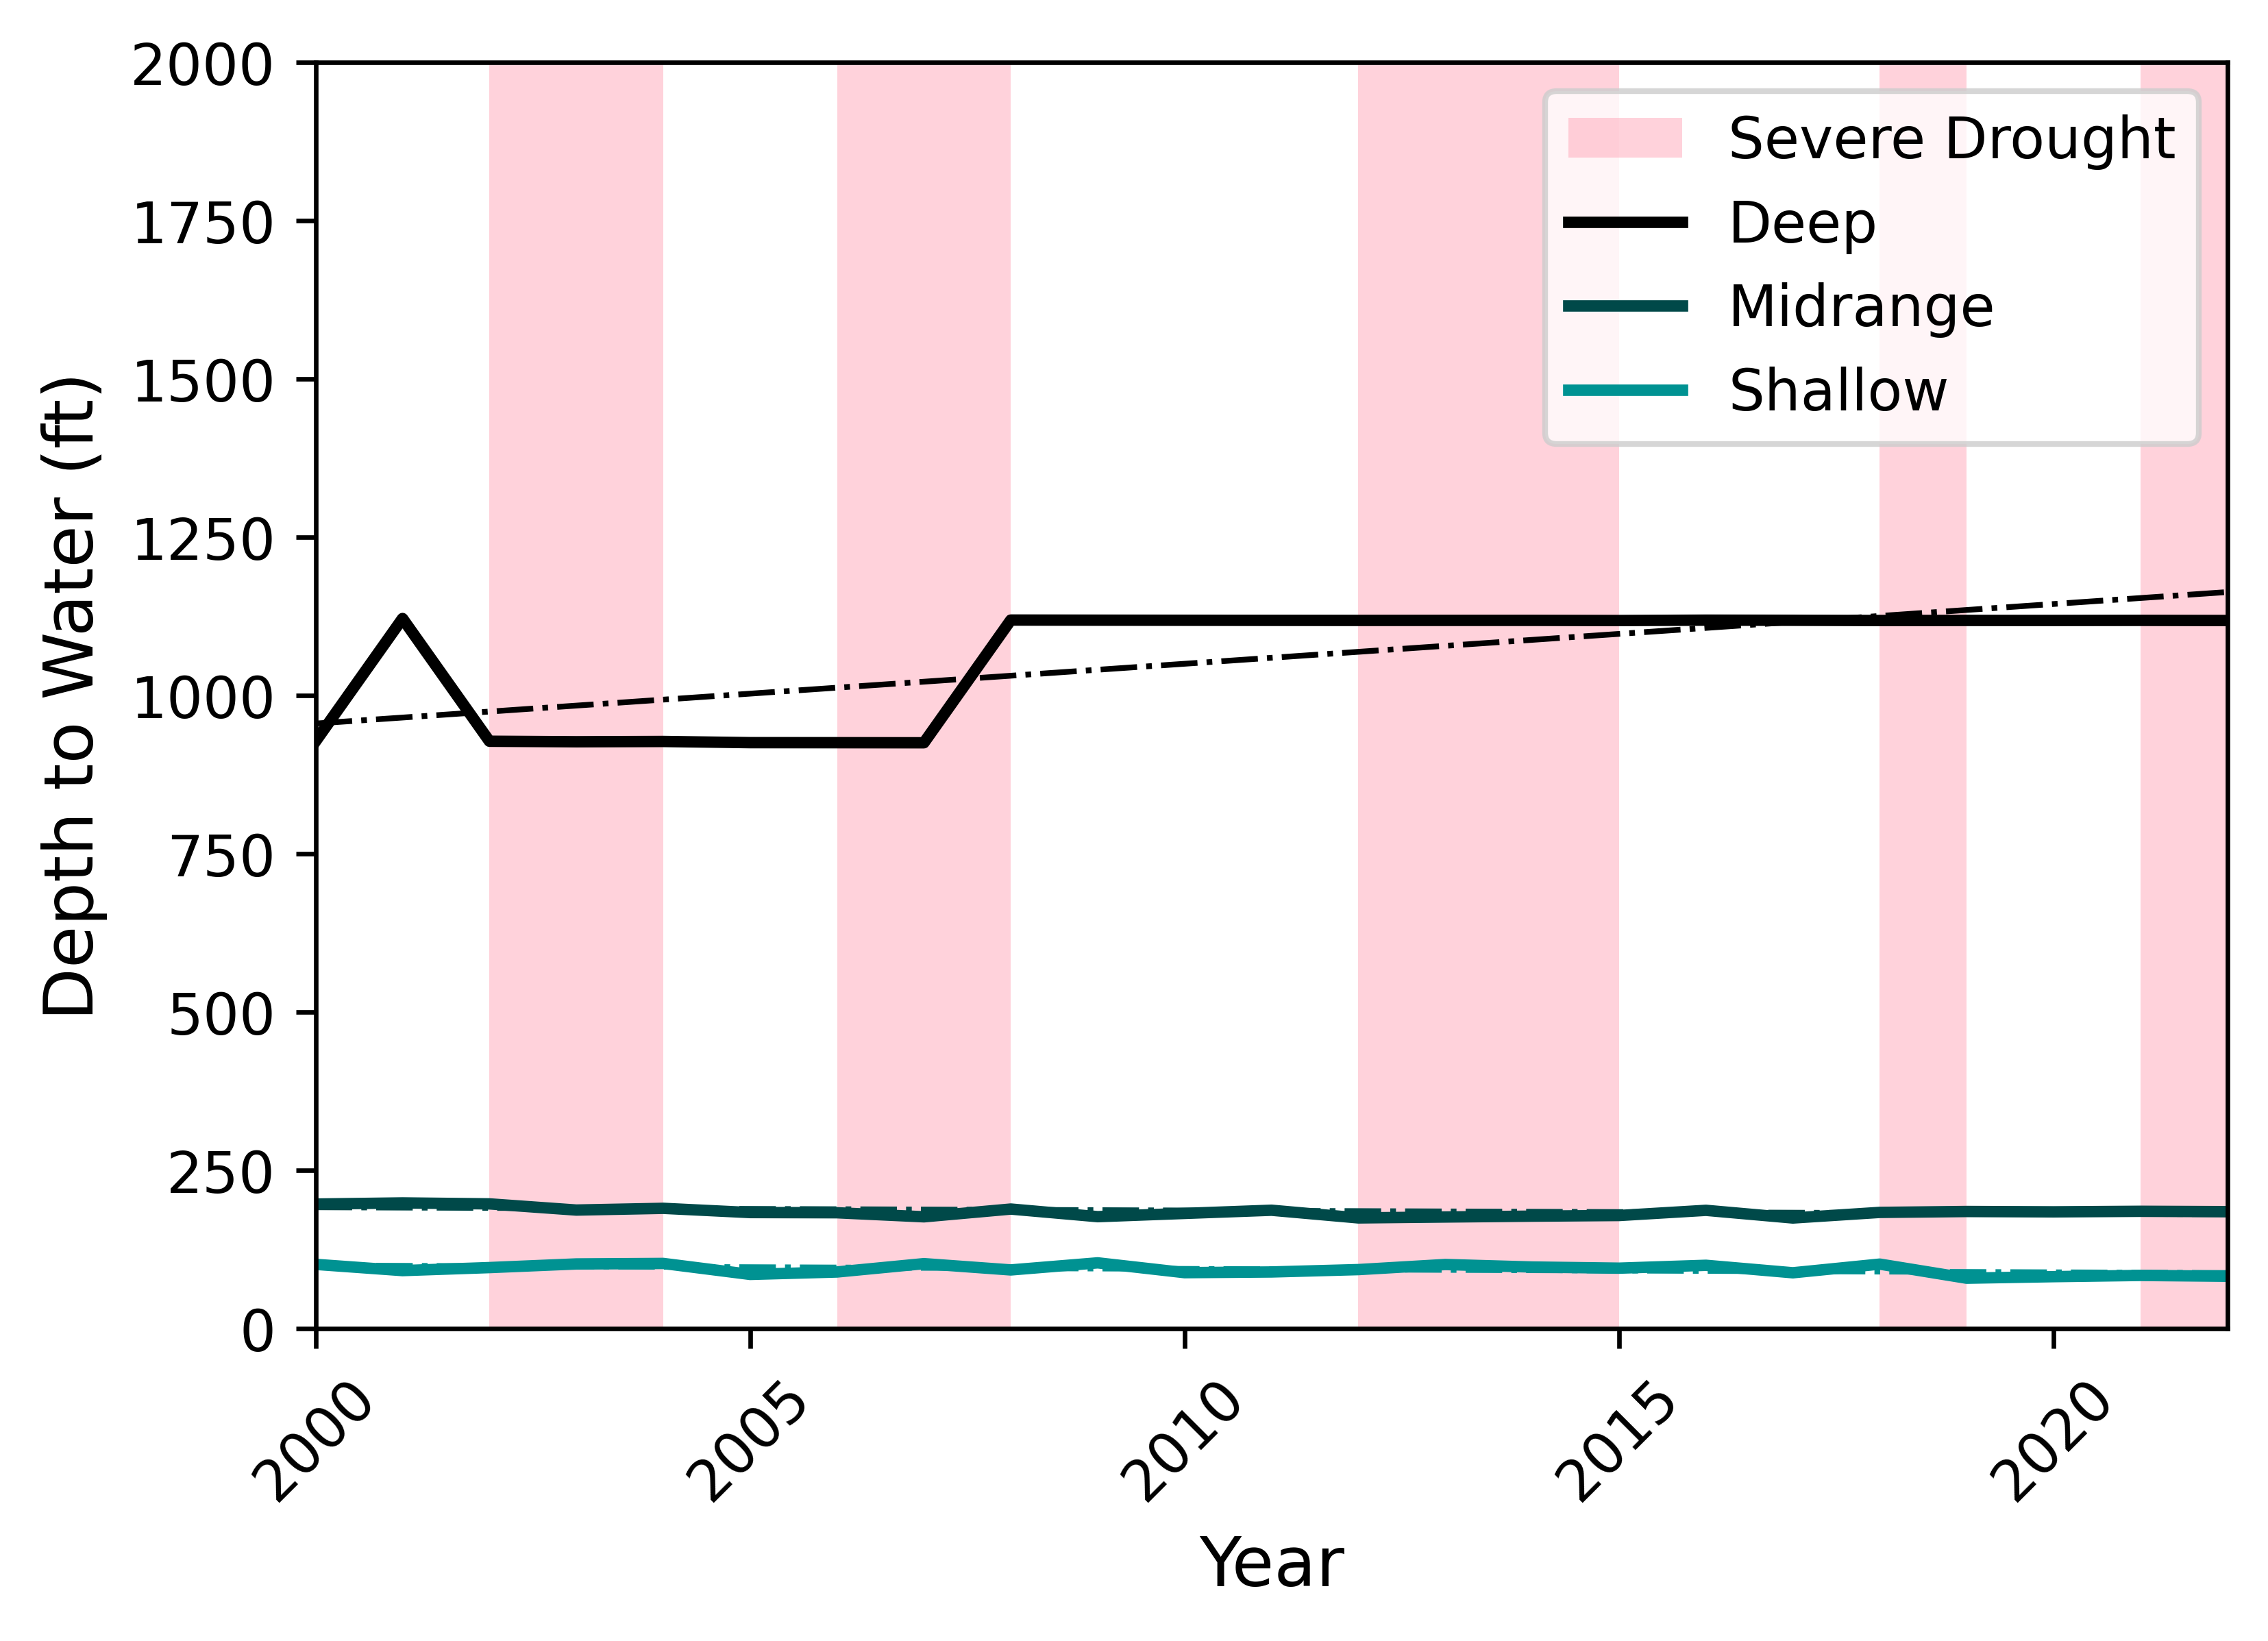

In [ ]:
# For Depth to Water by regulation
# ds = wlanalysis_period
ds = df_interpolated
min_yr = 2000
mx_yr = 2022
Name = "mean_"+StudyArea

# betterlabels = [StudyArea]
# betterlabels = ['Control','GSF/USF','USF']

f = ds[(ds.index >= min_yr) & (ds.index <= mx_yr)]
columns = ds.columns
column_list = ds.columns.tolist()

betterlabels = column_list

stats = pd.DataFrame()
# for i in range(1, 12, 1):
for i in column_list:
        df = f[i]
        #print(df)
        y=np.array(df.values, dtype=float)
        x=np.array(pd.to_datetime(df).index.values, dtype=float)
        slope, intercept, r_value, p_value, std_err =sp.linregress(x,y)
        stats = stats._append({'slope': slope, 
                              'int':intercept, 
                              'rsq':r_value*r_value, 
                              'p_val':p_value, 
                              'std_err':std_err, 
                              'mean': np.mean(y),
                              'var': np.var(y),
                              'sum': np.sum(y)
                              },
                              ignore_index=True)


stats.index = betterlabels
stats1 = stats.transpose()
print(stats1)
# stats1.to_csv(outputpath_local+'Stats_'+StudyArea+'.csv')

# -- Data visualization --
fig, ax = plt.subplots(1, 1, figsize = (6,4))

min_y = 0
max_y = 2000
fsize = 12

num_years = mx_yr - min_yr + 1
ax.set_xticks(np.linspace(min_yr, mx_yr, num_years))
ax.set_xticklabels(map(int, ax.get_xticks()))

# Drought Year Shading
ax.axvspan(DROUGHT_YEARS[3][0], DROUGHT_YEARS[3][1]+1, color=drought_color, alpha=0.5, lw=0
            , label="Severe Drought")
ax.axvspan(DROUGHT_YEARS[4][0], DROUGHT_YEARS[4][1]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[5][0], DROUGHT_YEARS[5][2]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[6][0], DROUGHT_YEARS[6][0]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[7][0], DROUGHT_YEARS[7][0]+1, color=drought_color, alpha=0.5, lw=0)

# Plotting the data
for i,j in zip(stats1.columns,color_list):
        ax.plot(ds[i],color=j, label=str(i),lw=2)
# ax.plot(ds[column_list[0]], color=water_designation)
# ax.plot(ds[column_list[0]], color=blind[1],label=betterlabels[0]) 
# ax.plot(ds[column_list[1]], color=blind[2],label=betterlabels[1]) 
# ax.plot(ds[column_list[2]], color=blind[6],label=betterlabels[2])  
xf = np.linspace(min(x),max(x),100)
xf1 = xf.copy()

# Plotting Trendlines
for i,j in zip(stats1.columns,color_list):
        #xf1 = pd.to_datetime(xf1)
        m1 = round(stats1.loc['slope',i], 2)
        yint1 = round(stats1.loc['int',i], 2)
        pval1 = round(stats1.loc['p_val',i], 4)
        yf1 = (m1*xf)+yint1
        # ax.plot(xf1, yf1,"-.",color=blind[j], lw=1)
        ax.plot(xf1, yf1,"-.",color=j, lw=1)

# Set x ticks to every 5 years:
xticks = np.arange(min_yr, mx_yr + 1, 5)
ax.set_xticks(xticks)

ax.set_xlim(min_yr,mx_yr)
ax.set_ylim(min_y,max_y)
# ax.grid(True)
# ax.grid(visible=True,which='major')
# ax.grid(which='minor',color='#EEEEEE', lw=0.8)
ax.set_xlabel('Year', fontsize=fsize)
ax.set_ylabel('Depth to Water (ft)',fontsize=fsize)
# ax.minorticks_on()
ax.tick_params(axis='x', rotation=45)
fig.set_dpi(600.0)
# ax.set_title('a)',loc='left',pad=15)
ax.legend(loc='upper right')

# plt.savefig(figurepath+Name, bbox_inches = 'tight')

Since Deep is just two wells, we'll conduct the analysis on midrange/shallow

             Deep  Midrange  Shallow
slope        9.44     -0.50    -0.54
int     -17924.18   1191.71  1179.84
rsq          0.50      0.24     0.23
p_val        0.00      0.02     0.02
std_err      2.06      0.19     0.22
mean      1060.45    184.39    93.66
var       7829.58     45.33    56.62
sum      24390.39   4240.87  2154.17


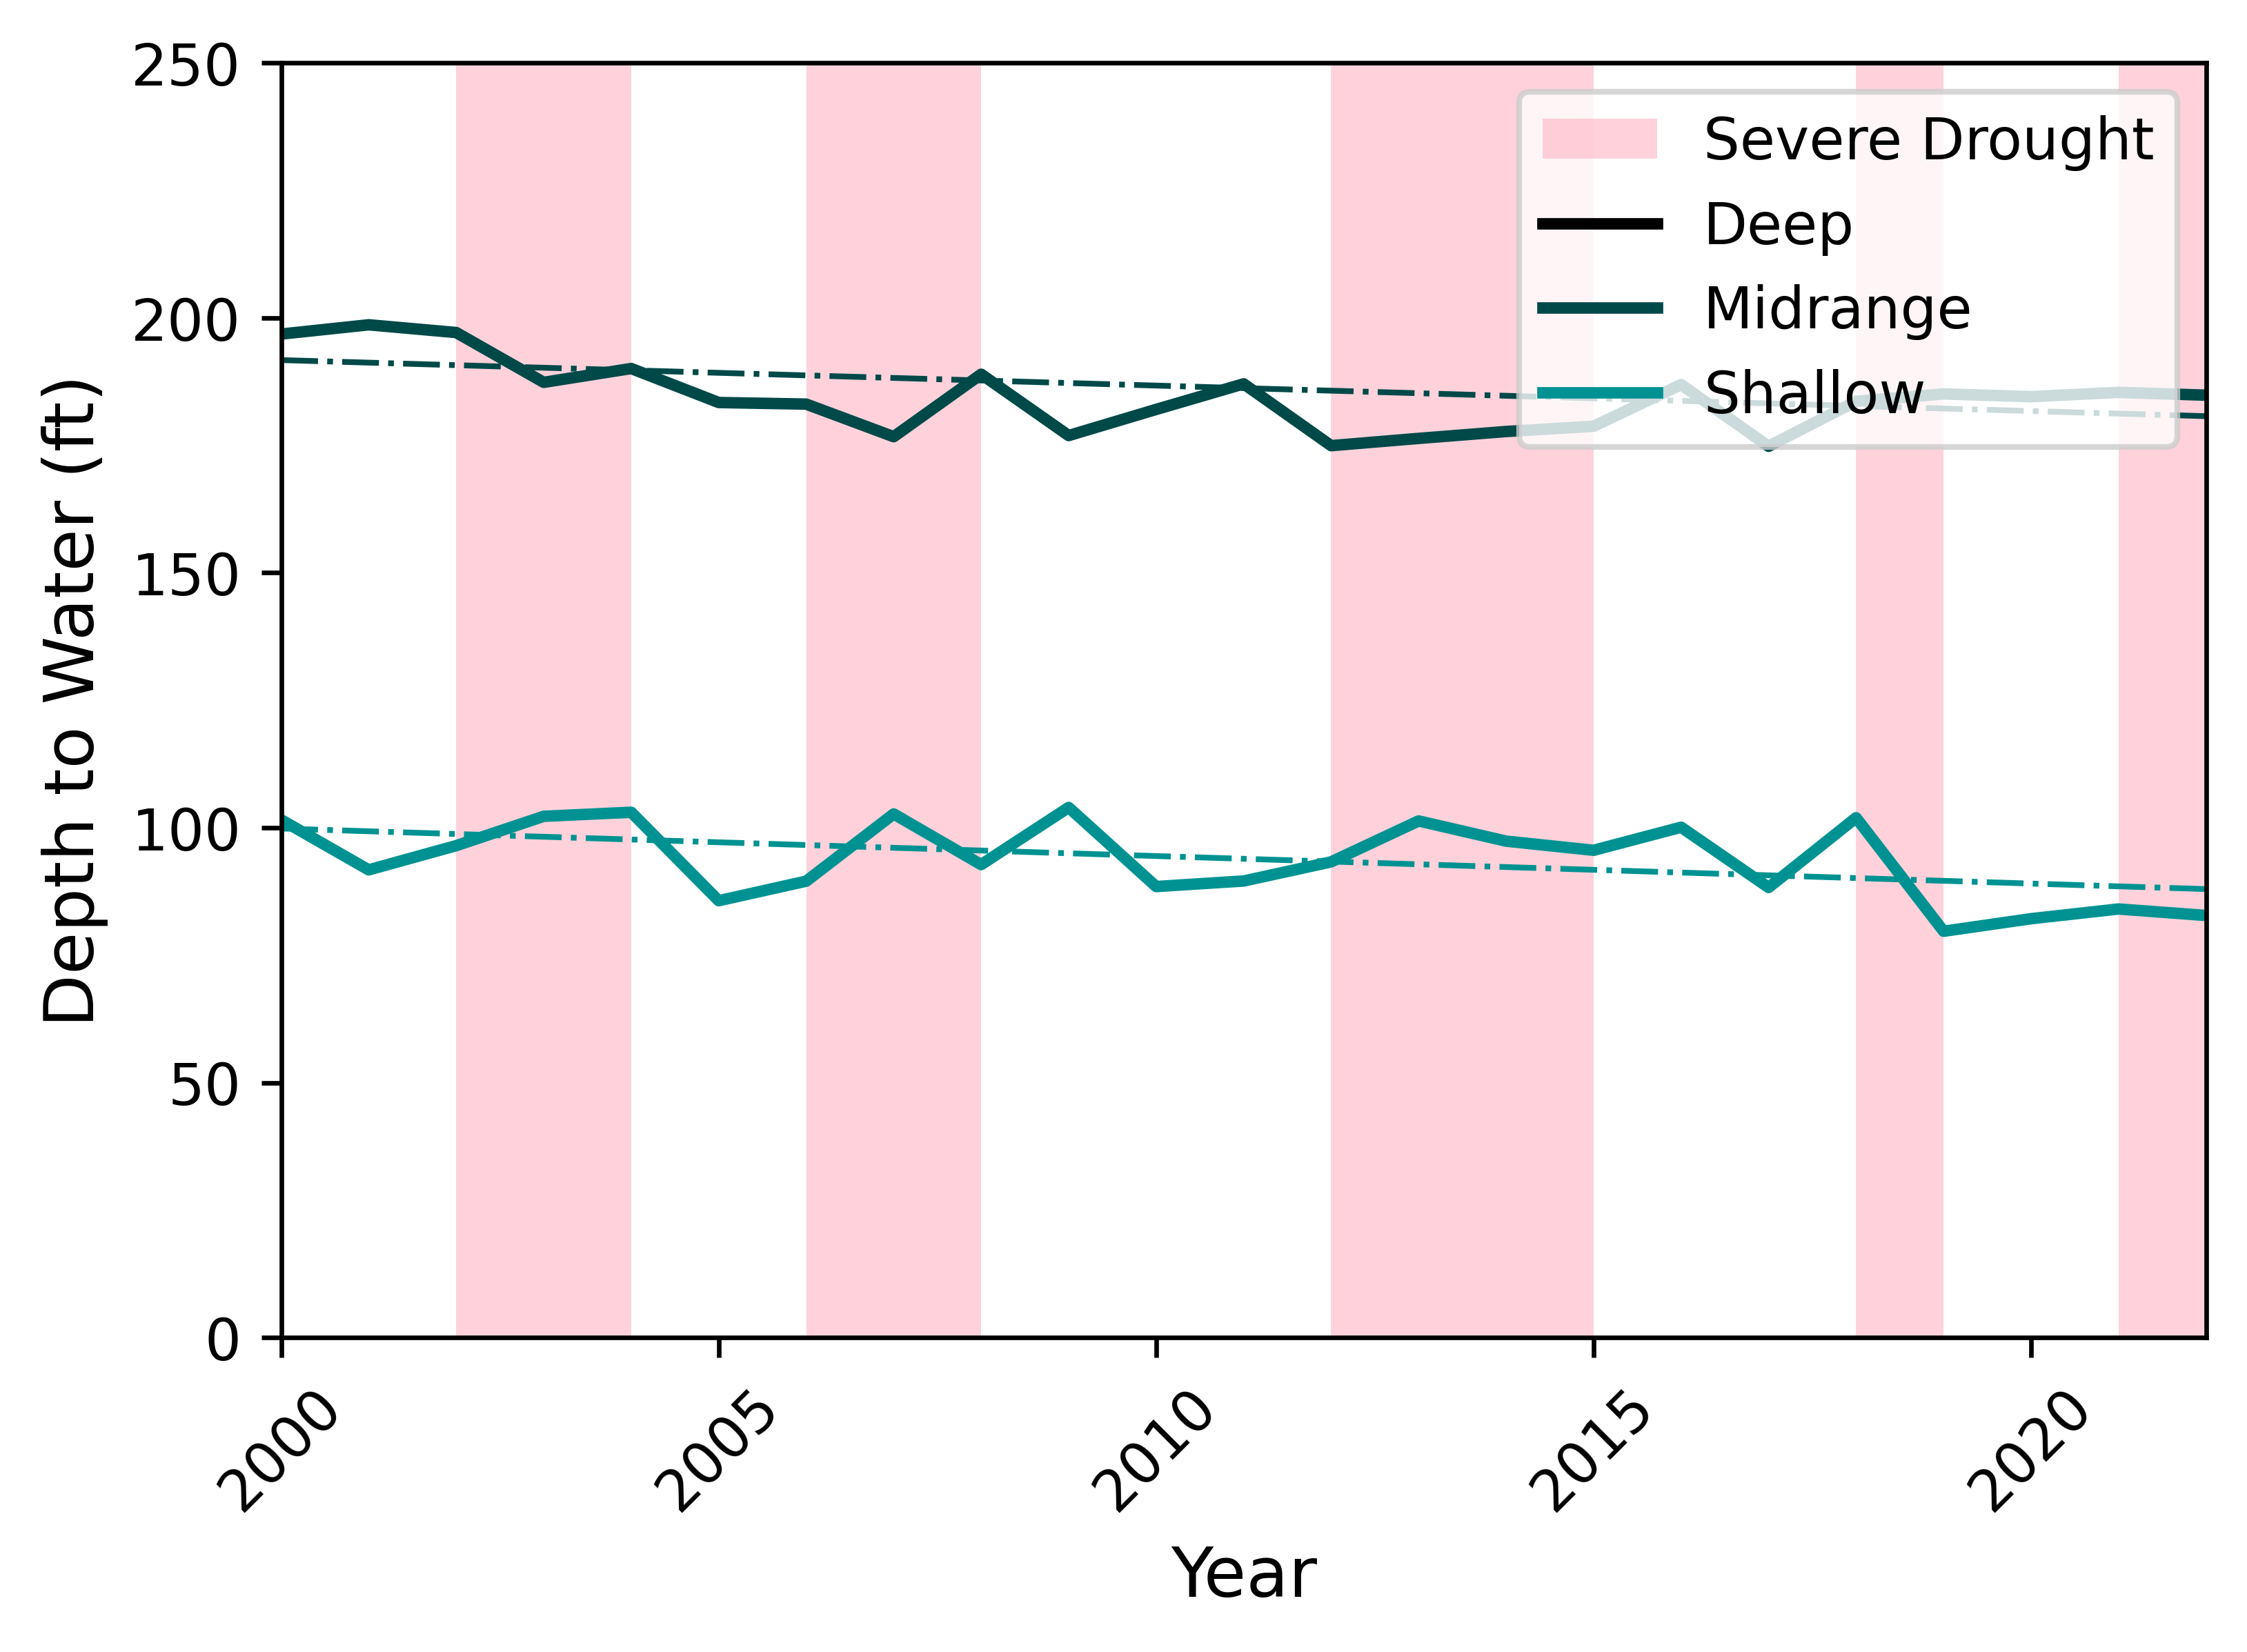

In [ ]:
# For Depth to Water by regulation
# ds = wlanalysis_period
ds = df_interpolated
min_yr = 2000
mx_yr = 2022
Name = "mean_"+StudyArea

# betterlabels = [StudyArea]
# betterlabels = ['Control','GSF/USF','USF']

f = ds[(ds.index >= min_yr) & (ds.index <= mx_yr)]
columns = ds.columns
column_list = ds.columns.tolist()

betterlabels = column_list

stats = pd.DataFrame()
# for i in range(1, 12, 1):
for i in column_list:
        df = f[i]
        #print(df)
        y=np.array(df.values, dtype=float)
        x=np.array(pd.to_datetime(df).index.values, dtype=float)
        slope, intercept, r_value, p_value, std_err =sp.linregress(x,y)
        stats = stats._append({'slope': slope, 
                              'int':intercept, 
                              'rsq':r_value*r_value, 
                              'p_val':p_value, 
                              'std_err':std_err, 
                              'mean': np.mean(y),
                              'var': np.var(y),
                              'sum': np.sum(y)
                              },
                              ignore_index=True)


stats.index = betterlabels
stats1 = stats.transpose()
print(stats1)
# stats1.to_csv(outputpath_local+'Stats_'+StudyArea+'.csv')

# -- Data visualization --
fig, ax = plt.subplots(1, 1, figsize = (6,4))

min_y = 0
max_y = 250
fsize = 12

num_years = mx_yr - min_yr + 1
ax.set_xticks(np.linspace(min_yr, mx_yr, num_years))
ax.set_xticklabels(map(int, ax.get_xticks()))

# Drought Year Shading
ax.axvspan(DROUGHT_YEARS[3][0], DROUGHT_YEARS[3][1]+1, color=drought_color, alpha=0.5, lw=0
            , label="Severe Drought")
ax.axvspan(DROUGHT_YEARS[4][0], DROUGHT_YEARS[4][1]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[5][0], DROUGHT_YEARS[5][2]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[6][0], DROUGHT_YEARS[6][0]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[7][0], DROUGHT_YEARS[7][0]+1, color=drought_color, alpha=0.5, lw=0)

# Plotting the data
for i,j in zip(stats1.columns,color_list):
        ax.plot(ds[i],color=j, label=str(i),lw=2)
# ax.plot(ds[column_list[0]], color=water_designation)
# ax.plot(ds[column_list[0]], color=blind[1],label=betterlabels[0]) 
# ax.plot(ds[column_list[1]], color=blind[2],label=betterlabels[1]) 
# ax.plot(ds[column_list[2]], color=blind[6],label=betterlabels[2])  
xf = np.linspace(min(x),max(x),100)
xf1 = xf.copy()

# Plotting Trendlines
for i,j in zip(stats1.columns,color_list):
        #xf1 = pd.to_datetime(xf1)
        m1 = round(stats1.loc['slope',i], 2)
        yint1 = round(stats1.loc['int',i], 2)
        pval1 = round(stats1.loc['p_val',i], 4)
        yf1 = (m1*xf)+yint1
        # ax.plot(xf1, yf1,"-.",color=blind[j], lw=1)
        ax.plot(xf1, yf1,"-.",color=j, lw=1)

# Set x ticks to every 5 years:
xticks = np.arange(min_yr, mx_yr + 1, 5)
ax.set_xticks(xticks)

ax.set_xlim(min_yr,mx_yr)
ax.set_ylim(min_y,max_y)
# ax.grid(True)
# ax.grid(visible=True,which='major')
# ax.grid(which='minor',color='#EEEEEE', lw=0.8)
ax.set_xlabel('Year', fontsize=fsize)
ax.set_ylabel('Depth to Water (ft)',fontsize=fsize)
# ax.minorticks_on()
ax.tick_params(axis='x', rotation=45)
fig.set_dpi(600.0)
# ax.set_title('a)',loc='left',pad=15)
ax.legend(loc='upper right')

# plt.savefig(figurepath+Name, bbox_inches = 'tight')

In [ ]:
# Anomaly's
ds = df_interpolated.copy()
columns = ds.columns
column_list = ds.columns.tolist()
trend_df = df_interpolated.copy()
dtw_anomalys = pd.DataFrame()
for i in column_list:
        # Subtracting against the mean
        # dtw_anomalys[i] = wlanalysis_period[i] - wlanalysis_period[i].mean()
        
        # Subtracting against the slope
        df = ds[i]
        y=np.array(df.values, dtype=float)
        x=np.array(pd.to_datetime(df).index.values, dtype=float)
        slope, intercept, r_value, p_value, std_err = sp.linregress(x,y)
        trend_df[i] = (df_interpolated.index*slope) + intercept
        dtw_anomalys[i] = df_interpolated[i] - trend_df[i]
        

dtw_anomalys.head()

,Deep,Midrange,Shallow
index,,,
2000,-28.78,6.92,1.94
2001,155.64,9.24,-7.33
2002,-47.64,8.22,-2.04
2003,-57.86,-1.05,4.25
2004,-66.87,2.16,5.58


In [ ]:
dtw_anomalys_nodeep = dtw_anomalys.copy()
del dtw_anomalys_nodeep['Deep']
dtw_anomalys_nodeep.head()

,Midrange,Shallow
index,,
2000,6.92,1.94
2001,9.24,-7.33
2002,8.22,-2.04
2003,-1.05,4.25
2004,2.16,5.58


In [ ]:
color_list = [cblind[1],cblind[2]]

Text(2000.5, 18, 'Dry')

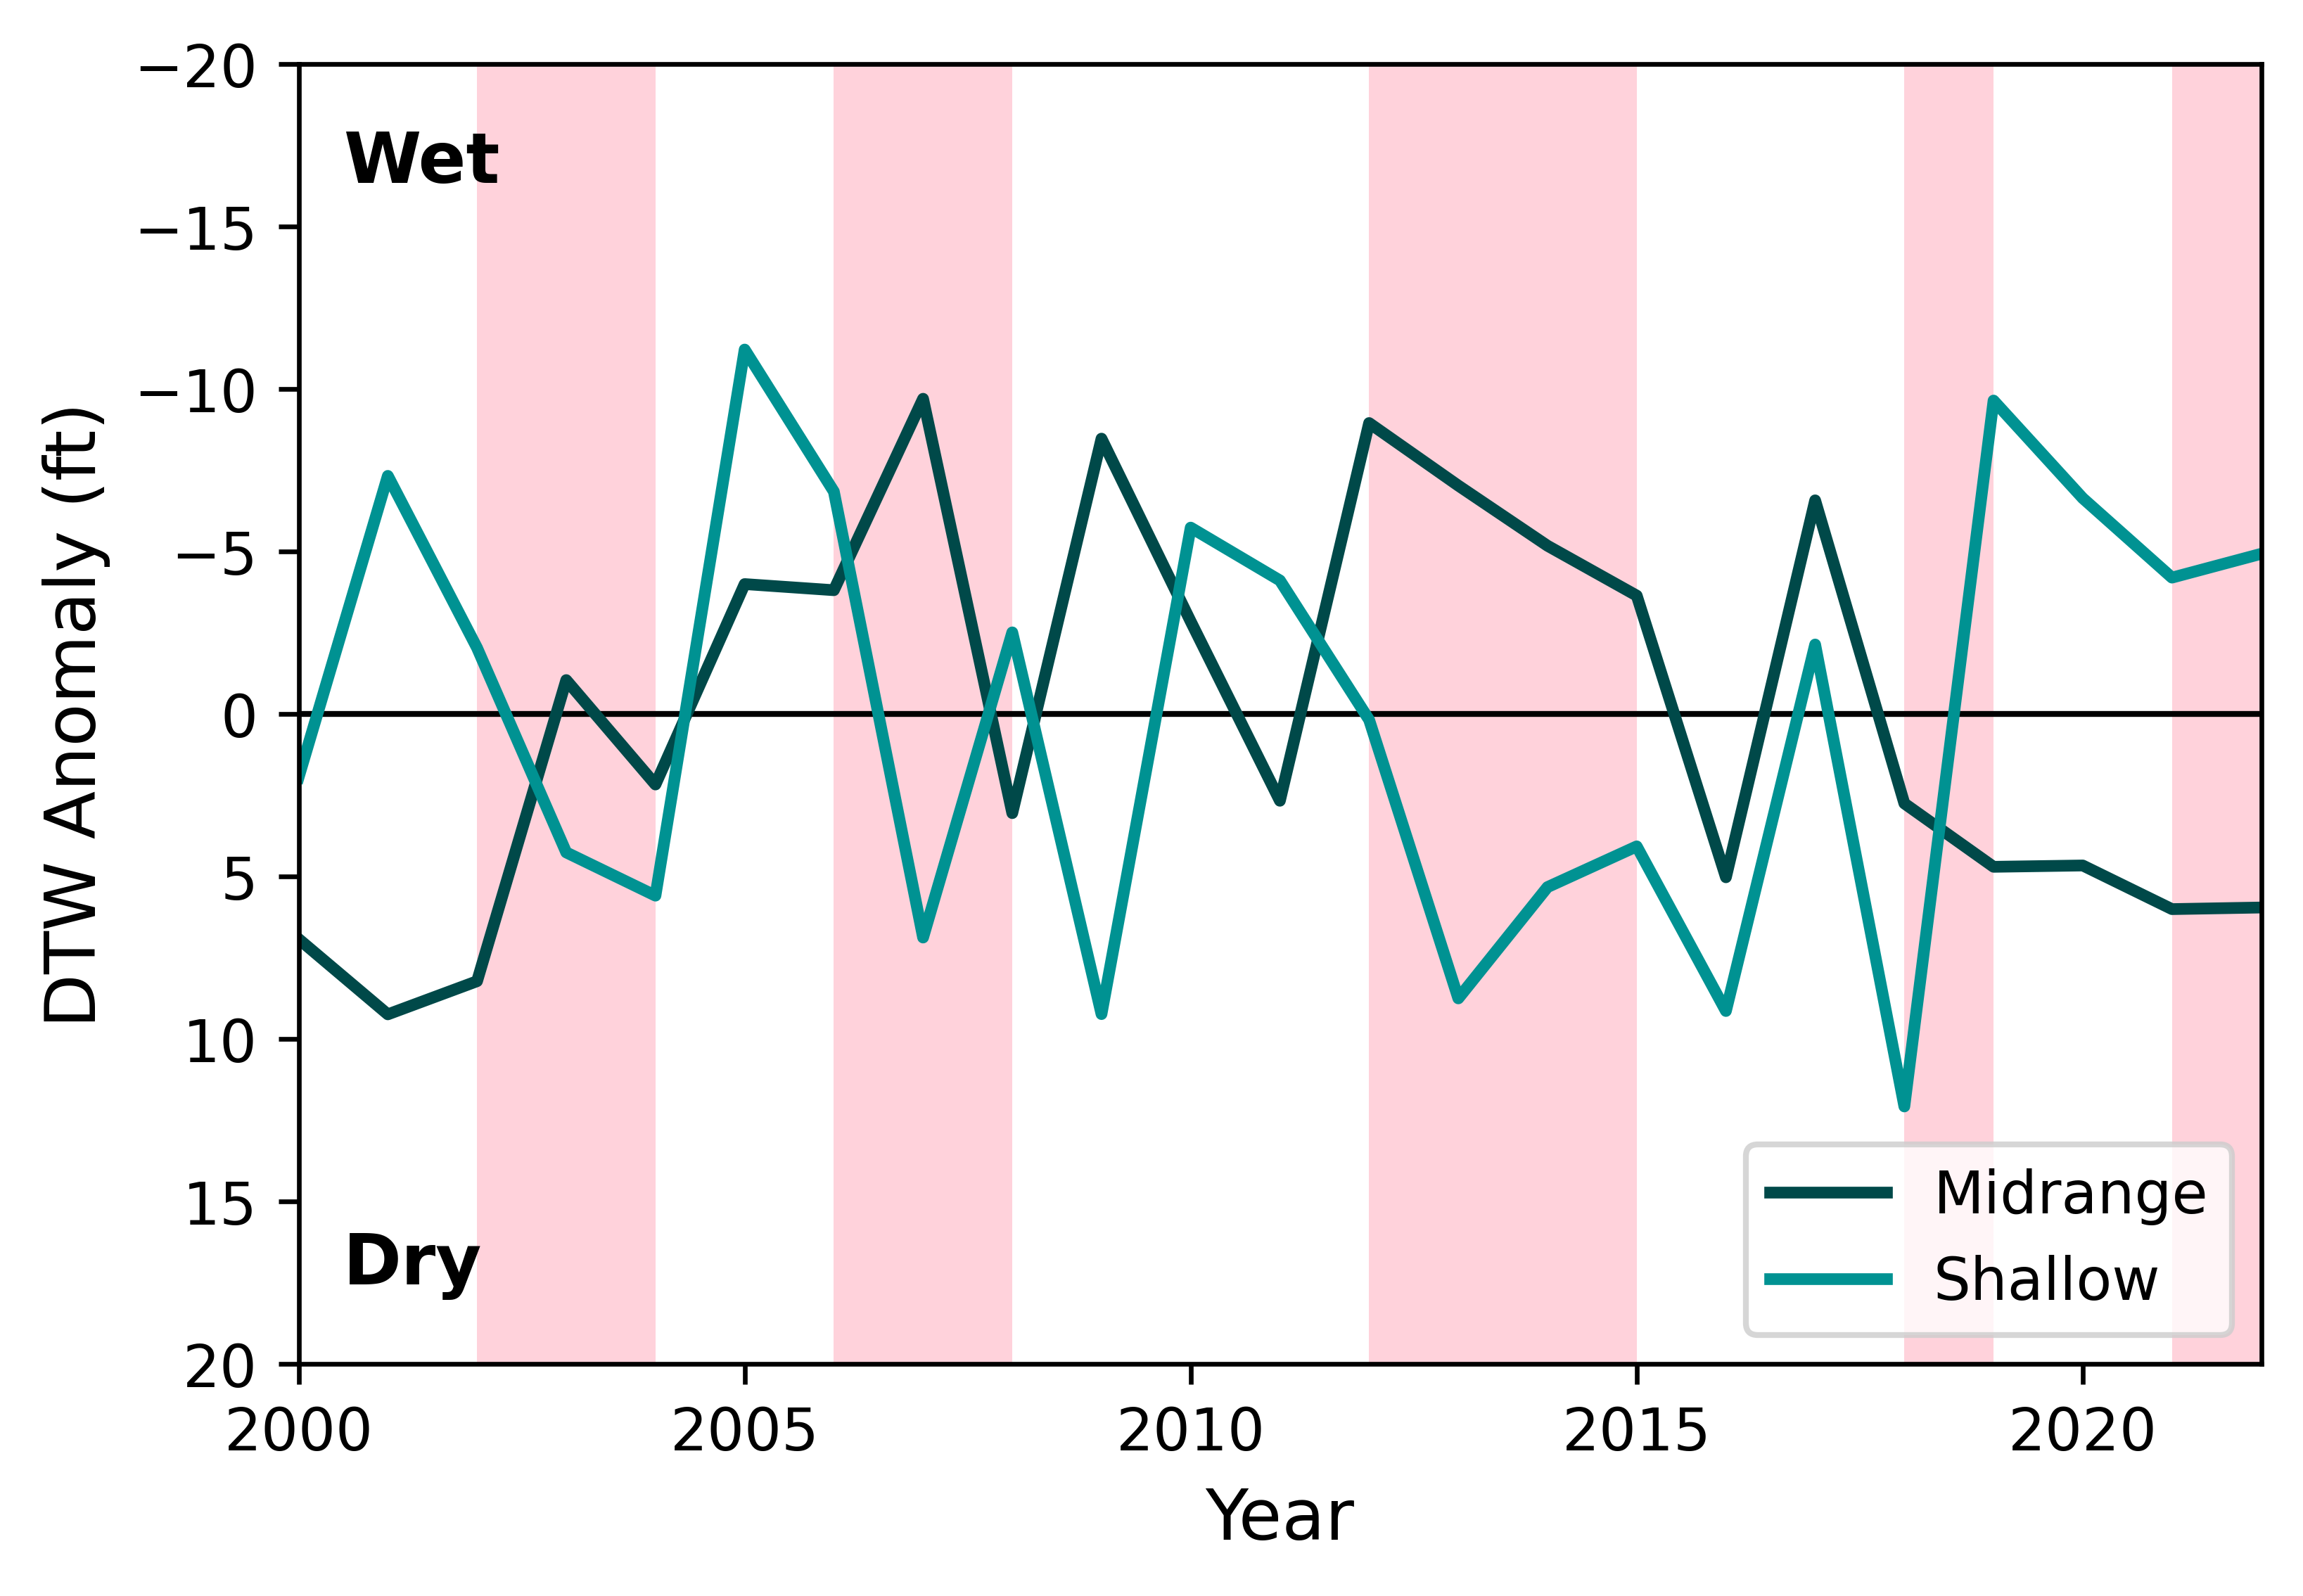

In [ ]:
ds = dtw_anomalys_nodeep
min_yr = 2000
mx_yr = 2022

columns = ds.columns
column_list = ds.columns.tolist()

fig, ax = plt.subplots(1, 1, figsize = (6,4))

ylim = 20
fsize = 12
# Set x ticks to every 5 years:
xticks = np.arange(min_yr, mx_yr + 1, 5)
ax.set_xticks(xticks)

ax.axvspan(DROUGHT_YEARS[3][0], DROUGHT_YEARS[3][1]+1, color=drought_color, alpha=0.5, lw=0
        #     , label="Severe Drought"
            )
ax.axvspan(DROUGHT_YEARS[4][0], DROUGHT_YEARS[4][1]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[5][0], DROUGHT_YEARS[5][2]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[6][0], DROUGHT_YEARS[6][0]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[7][0], DROUGHT_YEARS[7][0]+1, color=drought_color, alpha=0.5, lw=0)

plt.axhspan(0,0,color='black',lw=1)

for i,j in zip(ds.columns,color_list):
        ax.plot(ds[i],color=j, label=str(i),lw=2)

ax.set_xlim(min_yr,mx_yr)
ax.set_ylim(ylim,-ylim)
# ax.grid(True)
# ax.grid(visible=True,which='major')
# ax.grid(which='minor',color='#EEEEEE', lw=0.8)
ax.set_xlabel('Year', fontsize=fsize)
ax.set_ylabel('DTW Anomaly (ft)',fontsize=fsize)
# ax.minorticks_on()
ax.tick_params(axis='x', rotation=0)
fig.set_dpi(600.0)
# ax.set_title('a)',loc='left',pad=15)
ax.legend(loc='lower right')

# Adding text inside the plot
ax.text(min_yr+0.5, 2-ylim, 'Wet', fontsize=fsize, fontweight='bold', ha='left', va='top')
ax.text(min_yr+0.5, ylim-2, 'Dry', fontsize=fsize, fontweight='bold', ha='left', va='bottom')

# plt.savefig(figurepath+'Timeseries of DTW Anomalies for '+StudyArea, bbox_inches = 'tight')

In [ ]:
# %% Average Anomalie for drought periods
ds = dtw_anomalys.copy()
columns = ds.columns
column_list = ds.columns.tolist()

ds['Status'] = 'Normal-Wet'

for x,y in DROUGHT_YEARS.items():
        ds.loc[y, 'Status'] = 'Drought '+str(x)


dtw_max_anomalies = ds.groupby(['Status']).max()
dtw_max_anomalies
# ds

,Deep,Midrange,Shallow
Status,,,
Drought 3,-47.64,8.22,4.25
Drought 4,-87.72,-3.82,6.87
Drought 5,48.80,-5.18,8.75
Drought 6,-8.00,2.75,12.07
Drought 7,-36.10,6.00,-4.20
Normal-Wet,155.64,9.24,9.23


In [ ]:
test = dtw_max_anomalies.copy()
del test['Deep']

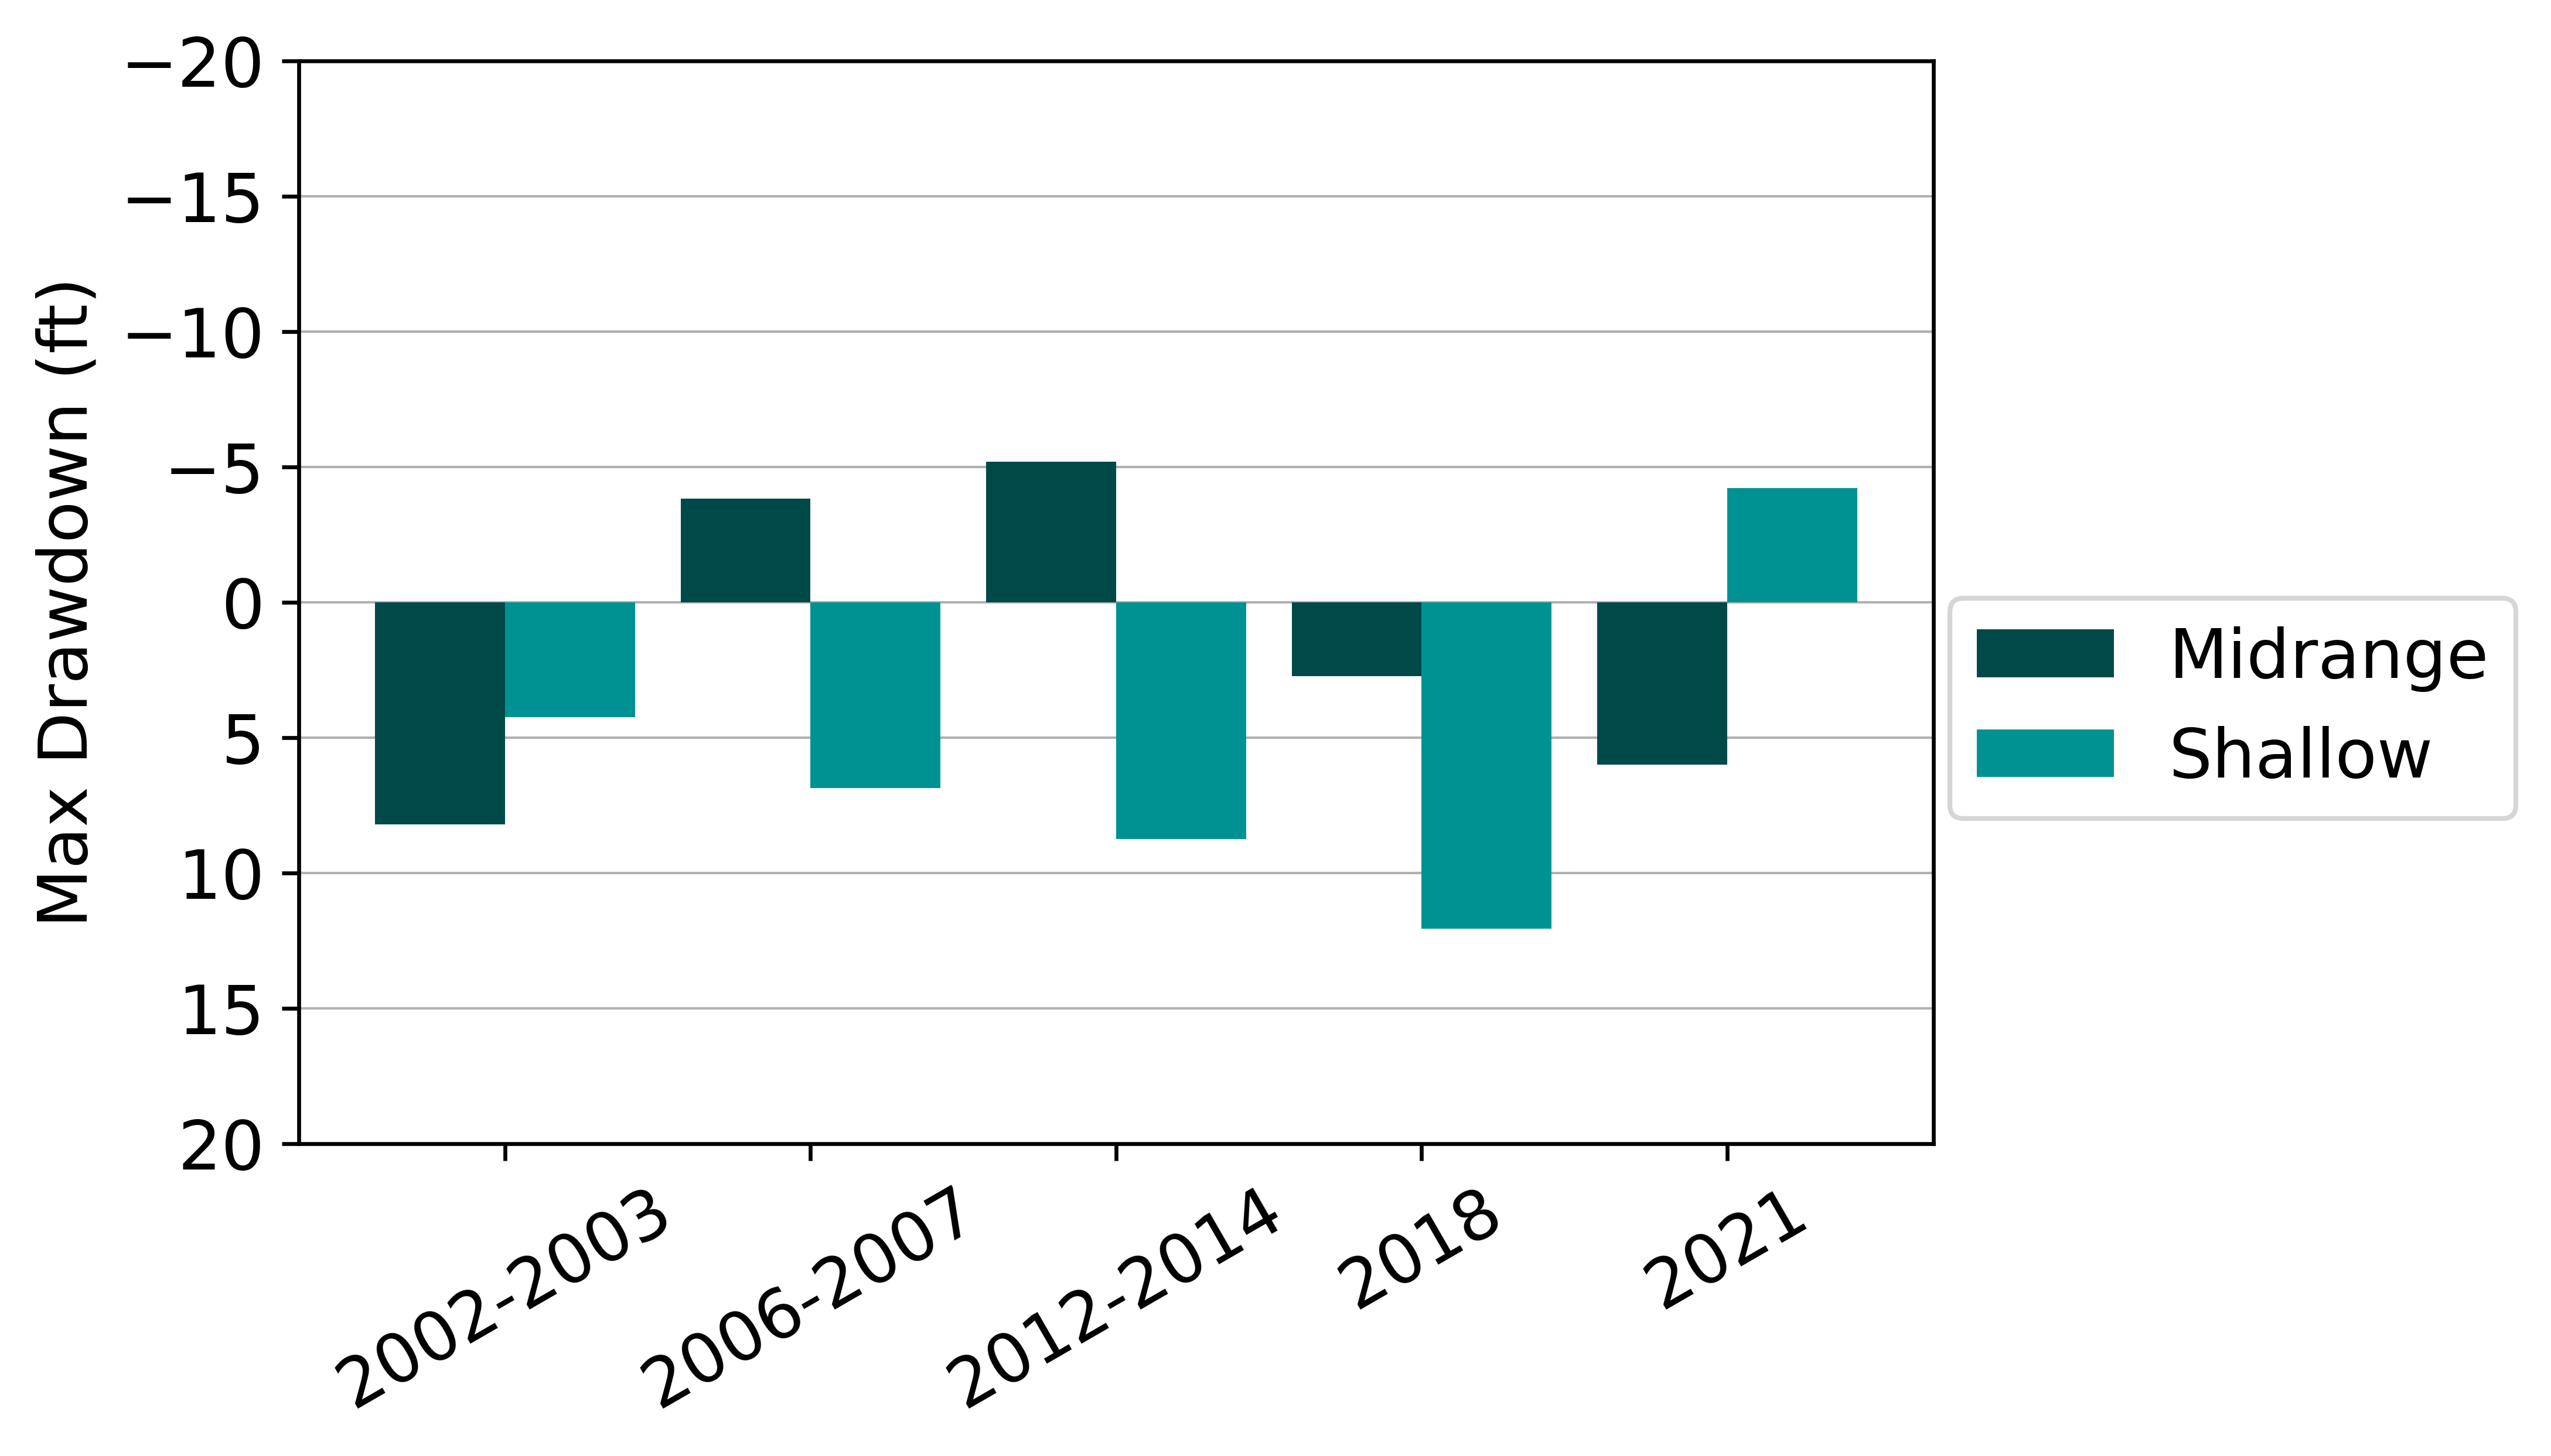

In [ ]:
# Customize this
name = 'Max Drawdown by Drought Period for '+StudyArea
ylim = 20
vertlabel = 'Max Drawdown (ft)'
fsize = 14

# Starting the plot
ds = test
yearlabels = [
              '2002-2003','2006-2007','2012-2014','2018','2021'
              ,'Normal/Wet Years'
        ]
betterlabels = ds.columns.tolist()

ds.index = yearlabels
ds = ds.transpose()
ds.index = betterlabels
del ds['Normal/Wet Years']
ds = ds.transpose()

group_colors = color_list

plt.rcParams["figure.dpi"] = 600
ds.plot(figsize = (6,4),
        kind='bar',
        stacked=False,
        # title=name,
        # color = group_colors,
        color = color_list,
        zorder = 2,
        width = 0.85,
        fontsize = fsize
        )
# plt.title(name, fontsize = (fsize+2))
plt.ylim([ylim,-ylim])
plt.ylabel(vertlabel, fontsize = fsize)
plt.xticks(rotation=30, fontsize = fsize)
plt.grid(axis='y', linewidth=0.5, zorder=0)
plt.legend(loc=[1.01,0.3],fontsize = fsize)
# plt.set_dpi(600)

# plt.savefig(figurepath+name+'_anomalies_groupedchart', bbox_inches = 'tight')